### 1.Import python packages

In [1]:
import json
from pathlib import *

import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import UnivariateSpline, splev, splrep
from scipy.optimize import curve_fit
from sympy import *
from lattice_inversion import get_shifts, generate_latinvpara_mix, generate_latinvpara, dzblSec, zblSec
from ase.data import atomic_numbers, atomic_names, atomic_masses, covalent_radii
import pandas as pd

### 2.全局变量

In [2]:
He_atom = 0.00168913
Ta_atom = -2.24248703
def combinfunc(f1, df1, potp, rin, z1, z2):
    c = f1(rin, *potp) - zblSec(rin, z1, z2)
    def func(r):
        result = np.where(r < rin, zblSec(r, z1, z2)+c, f1(r, *potp))
        return result
    def dfunc(r):
        result = np.where(r < rin, dzblSec(r, z1, z2), df1(r, *potp))
        return result
    return func, dfunc

def combinfunc_(f1, df1, rin, z1, z2):
    c = f1(rin) - zblSec(rin, z1, z2)
    def func(r):
        result = np.where(r < rin, zblSec(r, z1, z2)+c, f1(r))
        return result
    def dfunc(r):
        result = np.where(r < rin, dzblSec(r, z1, z2), df1(r))
        return result
    return func, dfunc

### 3.Calculate the LIP of Ta-He

#### 3.1 read data

In [3]:
oct_data = pd.read_csv("./lattice_inv_data/TaHe21_oct.csv", header=0)
tet_data = pd.read_csv("./lattice_inv_data/TaHe21_tet.csv", header=0)
print("OCT:--------------------\n", oct_data.head(6))
print("TET:--------------------\n", tet_data.head(6))
alat = np.array(oct_data['lat'])
deltaE = np.array((oct_data['energy'] - tet_data['energy'])/2)

OCT:--------------------
         lat      energy
0  2.000000  120.701367
1  2.081633  100.452544
2  2.163265   81.162776
3  2.244898   63.696569
4  2.326531   48.373508
5  2.408163   35.213506
TET:--------------------
         lat      energy
0  2.000000  121.112424
1  2.081633  100.647133
2  2.163265   81.235247
3  2.244898   63.702023
4  2.326531   48.281136
5  2.408163   34.965361


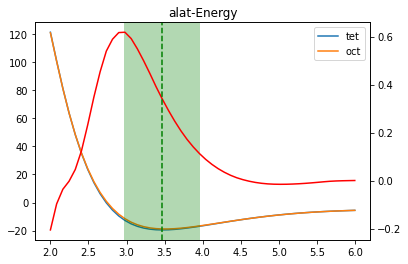

In [4]:
plt.plot(alat, tet_data['energy'], label='tet')
plt.plot(alat, oct_data['energy'], label='oct')
plt.legend()
plt.twinx()
plt.plot(alat, deltaE, label='deltaE', color='red')
plt.title("alat-Energy")

min_index1 = np.argmin(tet_data['energy'])
plt.axvspan(alat[min_index1]-0.5, alat[min_index1]+0.5, facecolor='g', alpha=0.3)
plt.axvline(alat[min_index1], color='g', linestyle='--')
plt.savefig("alat-Energy.png", dpi=300)

3.4693877551020407


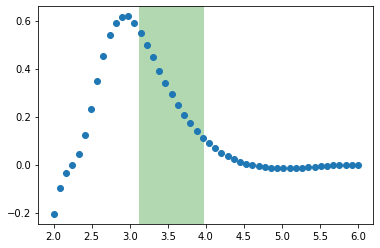

In [5]:
min_index1 = np.argmin(tet_data['energy'])
min_index2 = np.argmin(oct_data['energy'])
print(alat[min_index1])
plt.plot(alat, deltaE, 'o')
plt.axvspan(alat[min_index1]-0.35, alat[min_index1]+0.5, facecolor='g', alpha=0.3)

#### 3.2 fit

In [6]:
def meiDavenport(r, alpha, beta, gamma, r0):
    return -alpha * (1 + beta *(r/r0-1)) * np.exp(-gamma * (r/r0-1)**2)

def meiDavenport2(r, alpha, gamma, r0, n):
    return -alpha * np.exp(-gamma * (r/r0-1)**2)

def de_meiDavenport(r, alpha, gamma, r0, n):
    return 2*alpha*gamma*(r/r0 - 1)*np.exp(-gamma*(r/r0 - 1)**2)/r0

alpha, gamma, r0: [-1.00099902e-05  3.43423691e+05  5.99477841e+00  2.28209671e+00]


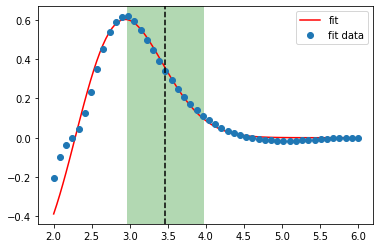

In [7]:
# idx = np.where((alat >= alat[min_index1]-0.18) & (alat <= alat[min_index1]+0.8))[0]
idx = np.where((alat >= 2.6) & (alat <= 4.4))[0]
alat_fit = alat[idx]
deltaE_fit = deltaE[idx]

# 拟合
popt, pcov = curve_fit(meiDavenport, alat_fit, deltaE_fit, p0=[-1, -1, 10, 3], maxfev=1000000)
plot_x = np.linspace(2, 6, 100)
plt.plot(plot_x, meiDavenport(plot_x, *popt), 'r-', label='fit')
plt.plot(alat, deltaE, 'o', label='fit data')
plt.axvline(alat[min_index1], color='k', linestyle='--')
plt.axvspan(alat[min_index1]-0.5, alat[min_index1]+0.5, facecolor='g', alpha=0.3)
plt.legend()
print("alpha, gamma, r0:", popt)

#### 3.3 LIP

In [8]:
bnArr, rnArr, InArr = generate_latinvpara_mix(get_shifts("oct"), get_shifts("tet"), NITEM=50)

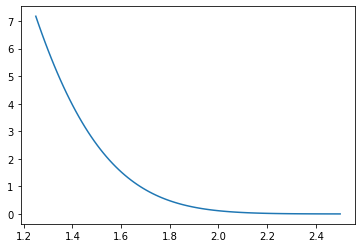

In [9]:
a = np.linspace(2.5, 5, 100)
en = np.sum(InArr.reshape(-1,1) * meiDavenport(bnArr.reshape(-1,1) * a, *popt), axis=0) * 2

plt.plot(a*0.5, en, label='inv')

c:\Users\wufeifeng\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\optimize\_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


alpha, beta, gamma, r0: [-26.43007002   0.65451755   0.51813076   4.        ]
[-1.17629206e-02 -7.21886094e-03 -3.42705582e-03 -3.33890321e-04
  2.11635652e-03  3.98069268e-03  5.31666027e-03  6.18164802e-03
  6.63226879e-03  6.72380132e-03  6.50969602e-03  6.04114382e-03
  5.36670737e-03  4.53201322e-03  3.57950335e-03  2.54824407e-03
  1.47378992e-03  3.88099703e-04 -6.80498322e-04 -1.70729575e-03
 -2.67115137e-03 -3.55440056e-03 -4.34273083e-03 -5.02502778e-03
 -5.59319559e-03 -6.04195654e-03 -6.36863354e-03 -6.57291997e-03
 -6.65664066e-03 -6.62350782e-03 -6.47887553e-03 -6.22949591e-03
 -5.88328011e-03 -5.44906677e-03 -4.93640025e-03 -4.35532082e-03
 -3.71616831e-03 -3.02940083e-03 -2.30542953e-03 -1.55447000e-03
 -7.86411087e-04 -1.07009803e-05  7.63749319e-04  1.52864554e-03
  2.27637322e-03  3.00004500e-03  3.69353308e-03  4.35148774e-03
  4.96934313e-03  5.54331141e-03  6.07036663e-03  6.54821942e-03
  6.97528393e-03  7.35063817e-03  7.67397909e-03  7.94557345e-03
  8.16620572

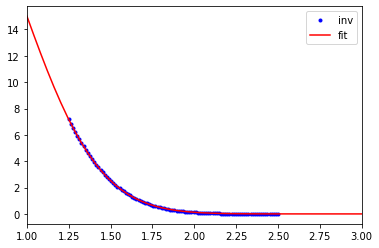

In [14]:
idx = np.where((a >=2) & (a <= 4.2))[0]
ra_fit = a[idx]
en_fit = en[idx]

plot_x = np.linspace(1, 5, 100)
popt, pcov = curve_fit(meiDavenport2, ra_fit*0.5, en_fit, maxfev=30000000, p0=[0, 3, 2, 4])
print("alpha, beta, gamma, r0:", popt)
plt.plot(a*0.5, en, "b.",label='inv')
plt.plot(plot_x, meiDavenport2(plot_x, *popt), 'r-', label='fit')
plt.xlim(1, 3)

plt.legend()
err = meiDavenport2(ra_fit*0.5, *popt) - en_fit
print(err)
plt.savefig("inv.png", dpi=300)

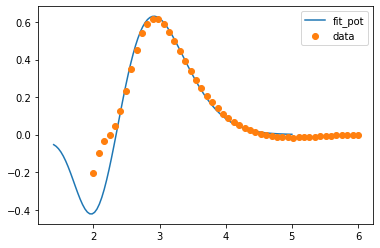

In [11]:
# deltaE
alat_fit = np.linspace(1.4, 5, 100)
deltaE_fit = np.sum(rnArr.reshape(-1,1) * meiDavenport2(bnArr.reshape(-1,1) * alat_fit * 0.5, *popt), axis=0) * 0.5

# oct
bnArr1, rnArr1, InArr1 = generate_latinvpara(get_shifts("oct"), NITEM=8)
bnArr2, rnArr2, InArr2 = generate_latinvpara(get_shifts("tet"), NITEM=8)

e1 = np.sum(rnArr1.reshape(-1,1) * meiDavenport2(bnArr1.reshape(-1,1) * alat_fit * 0.5, *popt), axis=0) * 0.5
e2 = np.sum(rnArr2.reshape(-1,1) * meiDavenport2(bnArr2.reshape(-1,1) * alat_fit * np.sqrt(5)/4, *popt), axis=0) * 0.5
deltaE_fit2 = e1 - e2

plt.plot(alat_fit, deltaE_fit, label='fit_pot')
plt.plot(alat, deltaE, 'o', label='data')

plt.legend()

(1.0, 3.0)

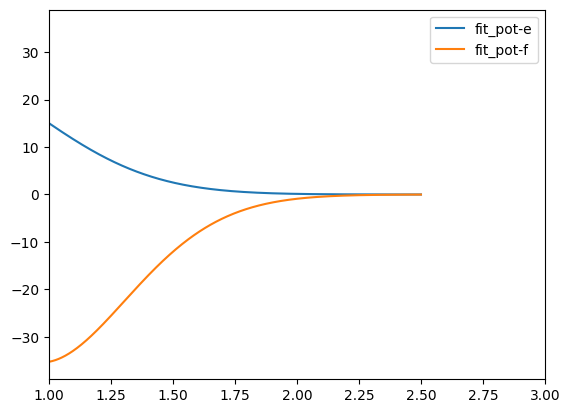

In [12]:
r = np.linspace(0, 2.5, 1000)
pe = meiDavenport2(r, *popt)
pf = de_meiDavenport(r, *popt)
plt.plot(r, pe, label='fit_pot-e')
plt.plot(r, pf, label='fit_pot-f')
plt.legend()
plt.xlim(1, 3)

#### 3.4 输出Ta-He的插值列表

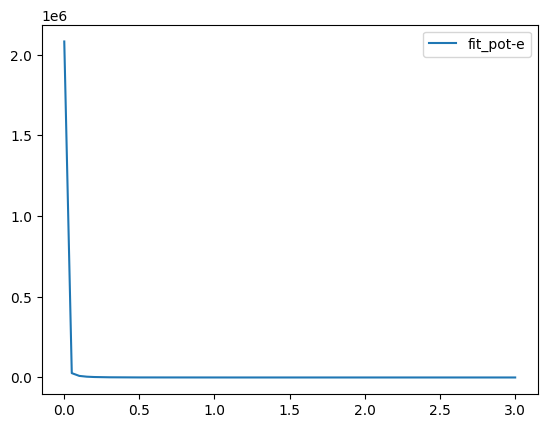

In [13]:
rArr = np.concatenate((np.linspace(0.001, 1, 20, endpoint=False),np.linspace(1, 3, 200)),axis=0)
# rArr = np.concatenate((np.linspace(1e-5, 1, 100),np.linspace(1, 2.5, 200)),axis=0)
rin = 1
e_func, f_func = combinfunc(meiDavenport2, de_meiDavenport, popt, rin, atomic_numbers['Ta'], atomic_numbers['He'])

pe_TaHe = e_func(rArr)
pf_TaHe = f_func(rArr)

plt.plot(rArr, pe_TaHe, label='fit_pot-e')
# plt.plot(rArr, pf_TaHe, label='fit_pot-f')
plt.legend()

data = np.vstack((rArr, pe_TaHe,-pf_TaHe)).T
with open("./out/TaHe.csv",'w') as f:
    f.write("r,E,F\n")
    for i in data:
        f.write(f"{i[0]},{i[1]},{i[2]}\n")